# Description

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

- `Name` — название игры;
- `Platform` — платформа;
- `Year_of_Release` — год выпуска;
- `Genre` — жанр игры;
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий);
- `EU_sales` — продажи в Европе (миллионы проданных копий);
- `JP_sales` — продажи в Японии (миллионы проданных копий);
- `Other_sales` — продажи в других странах (миллионы проданных копий);
- `Critic_Score` — оценка критиков (максимум 100);
- `User_Score` — оценка пользователей (максимум 10);
- `Rating` — рейтинг от организации ESRB.

Возможные значения рейтинга:

- `EC` (Early Childhood) - «Для детей младшего возраста»: для детей от 3 лет;
- `E` (Everyone) - «Для всех»: для возрастной категории от 6 лет;
- `E10+` (Everyone 10+) - «Для всех от 10 лет и старше»;
- `T` (Teen) - «Подросткам»: для лиц от 13 лет;
- `M` (Mature) - «Для взрослых»: не подходит для подростков младше 17 лет;
- `AO` (Adults Only 18+) - «Только для взрослых»: для взрослых старше 18 лет;
- `RP` (Rating Pending) - «Рейтинг ожидается»: продукт ожидает присвоения рейтинга.


# Import libraries

In [816]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

In [8]:
def percent_missing(df):
    missing_num = df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing_data = pd.concat([missing_num,missing_perc],keys=['Total','Percentage'],axis=1)
    missing_data = missing_data[missing_data['Percentage']>0]
       
    return missing_data

# Data preprocessing

In [431]:
df = pd.read_csv('./games.csv')

In [91]:
df = pd.read_csv('./games.csv')
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
11074,Champion Jockey: G1 Jockey & Gallop Racer,Wii,2011.0,Sports,0.04,0.03,0.01,0.01,NaN,NaN,NaN
13737,Battle Spirits: Digital Starter,DS,2010.0,Role-Playing,0.00,0.00,0.04,0.00,NaN,NaN,NaN
5752,Peppa Pig: Theme Park Fun,DS,2011.0,Misc,0.00,0.27,0.00,0.04,NaN,NaN,NaN
3895,Jam With the Band,DS,2008.0,Misc,0.00,0.00,0.51,0.00,NaN,NaN,NaN
4284,NASCAR 2005: Chase for the Cup,XB,2004.0,Racing,0.34,0.10,0.00,0.02,86.0,tbd,E
10407,Big League Sports: Summer,DS,2009.0,Sports,0.09,0.00,0.00,0.01,NaN,tbd,E
3036,Tony Hawk's Proving Ground,PS2,2007.0,Sports,0.55,0.02,0.00,0.09,65.0,6.6,T
14590,Tenka-bito,PS2,2006.0,Strategy,0.00,0.00,0.03,0.00,NaN,NaN,NaN
15720,Touch Detective (JP sales),DS,2006.0,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
1462,NBA 2K15,PS3,2014.0,Sports,0.87,0.21,0.02,0.24,NaN,3.5,E


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [92]:
percent_missing(df)

,Total,Percentage
Critic_Score,8578,51.319174
Rating,6766,40.478612
User_Score,6701,40.089740
Year_of_Release,269,1.609333
Name,2,0.011965
Genre,2,0.011965


- Много пропущенных значений в колонках оценок критиков, игроков, рейтинга;
- Тип данных года релиза - `float`, следует поменять на `int`;
- Тип данных оценки пользователей - `object`.

In [432]:
# Приводим колонки к нижнему регистру для удобства
df.columns = df.columns.str.lower()

Обработаем дубли

In [209]:
# Проверяем дубли
df.duplicated().sum()

0

In [327]:
df[df.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [433]:
df.dropna(subset=['name'], inplace=True)

В строке с названией игры встречаются комментарии в скобках, взгляним на них

In [434]:
df[df['name'].str.contains('(',regex=False)].sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15698,The King of Fighters Collection: The Orochi Sa...,PS2,2006.0,Fighting,0.00,0.00,0.02,0.00,NaN,NaN,NaN
8728,Dragon Ball Z: Harukanaru Densetsu (JP sales),DS,2007.0,Role-Playing,0.00,0.00,0.15,0.00,NaN,NaN,NaN
13571,Sonic the Hedgehog 2 (8-bit),GG,1992.0,Platform,0.00,0.00,0.04,0.00,NaN,NaN,NaN
14298,Project Gotham Racing 2 (JP weekly sales),XB,2003.0,Action,0.00,0.00,0.03,0.00,NaN,NaN,NaN
3353,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",X360,2007.0,Action,0.51,0.04,0.00,0.05,NaN,NaN,NaN
15568,"Transformers: Revenge of the Fallen (XBox 360,...",PC,2009.0,Shooter,0.02,0.00,0.00,0.00,NaN,NaN,NaN
12720,The Amazing Spider-Man 2 (2014),WiiU,2014.0,Action,0.03,0.02,0.00,0.00,NaN,NaN,NaN
6255,The Legend of Zelda: The Minish Cap(weekly JP ...,GBA,NaN,Action,0.00,0.00,0.27,0.01,NaN,NaN,NaN
6164,The Urbz: Sims In the City (US weekly sales),DS,2004.0,Simulation,0.26,0.00,0.00,0.02,NaN,NaN,NaN
7253,The Amazing Spider-Man 2 (2014),XOne,2014.0,Action,0.12,0.08,0.00,0.02,NaN,NaN,NaN


In [435]:
df[df['name'].str.contains("Transformers: The Game")]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1837,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",PS2,2007.0,Action,0.63,0.37,0.00,0.11,NaN,NaN,NaN
3103,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",PSP,2007.0,Action,0.23,0.26,0.00,0.16,NaN,NaN,NaN
3353,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",X360,2007.0,Action,0.51,0.04,0.00,0.05,NaN,NaN,NaN
3510,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",Wii,2007.0,Action,0.50,0.03,0.00,0.05,NaN,NaN,NaN
4844,"Transformers: The Game (XBox 360, PS2, PS3, Wi...",PS3,2007.0,Action,0.32,0.03,0.01,0.04,NaN,NaN,NaN


In [364]:
comments = list(map(lambda name: name[name.find('(')+1:name.find(')')],
    df[df['name'].str.contains('(',regex=False)]['name'].str.lower()
))

In [297]:
set(comments)

{'2006',
 '2008',
 '2009',
 '2010',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '3ds',
 '8-bit',
 'all region sales',
 'all regions sales',
 'america weekly sales',
 'american and others sales',
 'american sales',
 'cd',
 'codemasters',
 'console version',
 'correct us sales',
 'ds & mobile versions',
 'ds version',
 'ds versions',
 'ebkore+',
 'gbc',
 'higher jp sales',
 'insomniac',
 'japan',
 'japan sales',
 'joukan',
 'jp',
 'jp & incomplete us sales',
 'jp & others sales',
 'jp sales',
 'jp sales, but wrong system',
 'jp version',
 'jp weekly sales',
 'koei',
 'north america',
 'old all region sales',
 'old jp sales',
 'old us sales',
 'online edition',
 'others sales',
 'pal',
 'ps1 & psp versions',
 'psp',
 'red',
 'remake',
 'rp-m',
 'rp-t',
 'ryoku',
 'sales, but wrong system',
 'telltale',
 'us & others sales',
 'us sales',
 'us weekly sales',
 'weekly american sales',
 'weekly jp sales',
 'wii & ps2 version',
 'xbox 360, ps2, ps3, wii & pc versions',
 'xbox 360, ps3, & pc 

Комментарии в наименовании представляют собой следующее:
* Год выпуска на платформе, регион в котором она вышла (во многих играх существуют некоторые изменения в соответсвтии с законодательством страны в котором игра выходит);
* Платформа на которой игра выпускается;
* Распродажа игр.

Данные комментарии лучше убрать и сгруппировать игры.

In [436]:
# удаляем содержимое в скобках
df['name'] = df['name'].str.replace(r'\s*\([^)]*\)', '')

In [299]:
df.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [437]:
# Заменяем tbd на NaN и преобразуем тип во float
df['user_score'] = df['user_score'].replace('tbd', np.nan)\
.astype(float)

In [301]:
ratings = df.rating.unique()

In [438]:
df = df.groupby(['name', 'platform']).agg({
    'year_of_release': 'min',
    'genre': 'first',
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum',
    'critic_score': 'mean',
    'user_score': 'mean',
    'rating': lambda x: min(filter(lambda r: r in ratings, x)) if len(list(filter(lambda r: r in ratings, x))) > 0 else None
}).reset_index()

In [303]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Beyblade Burst,3DS,2016.0,Role-Playing,0.00,0.00,0.03,0.00,NaN,NaN,None
1,Fire Emblem Fates,3DS,2015.0,Role-Playing,0.81,0.23,0.52,0.11,NaN,NaN,None
2,Frozen: Olaf's Quest,3DS,2013.0,Platform,0.27,0.27,0.00,0.05,NaN,NaN,None
3,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,None
4,Haikyu!! Cross Team Match!,3DS,2016.0,Adventure,0.00,0.00,0.04,0.00,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
16574,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.00,0.20,71.0,NaN,E
16575,uDraw Studio: Instant Artist,Wii,2011.0,Misc,0.06,0.09,0.00,0.02,NaN,NaN,E
16576,uDraw Studio: Instant Artist,X360,2011.0,Misc,0.01,0.01,0.00,0.00,54.0,5.7,E
16577,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,None


In [240]:
df['name'].value_counts().head(10)

Need for Speed: Most Wanted                10
Madden NFL 07                               9
Ratatouille                                 9
LEGO Marvel Super Heroes                    9
FIFA 14                                     9
LEGO Jurassic World                         8
FIFA Soccer 13                              8
LEGO Star Wars II: The Original Trilogy     8
Angry Birds Star Wars                       8
Monopoly                                    8
Name: name, dtype: int64

In [304]:
df[df['name'].str.contains("Need for Speed: Most Wanted")]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
9624,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E
9625,Need for Speed: Most Wanted,GBA,2005.0,Racing,0.19,0.07,0.00,0.00,NaN,8.3,E
9626,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
9627,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.29,0.00,0.06,82.0,8.5,T
9628,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
9629,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,None
9630,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,None
9631,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,None
9632,Need for Speed: Most Wanted,X360,2005.0,Racing,1.62,0.91,0.03,0.25,83.0,8.5,T
9633,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T


* Многие игры выпускаются сразу на несколько платформ;
* Существуют переиздания игры на одной и той же платформе;
* Рейтинг игры может быть изменен.

In [368]:
percent_missing(df)

,Total,Percentage
user_score,8996,54.261415
critic_score,8448,50.956029
rating,6638,40.038603
year_of_release,263,1.586344


Заменим пропуски в тех играх, которые были оценены средним значением. Рейтинг первым вхождением.

In [439]:
df['user_score'] = df['user_score'] * 10
df['user_score'] = df['user_score'].fillna(df.groupby('name')['user_score']
                                           .transform('mean').round(0))
df['critic_score'] = df['critic_score'].fillna(df.groupby('name')['critic_score']
                                               .transform('mean').round(0))
df['rating'] = df['rating'].fillna(
    df.groupby('name')['rating'].transform('first'))

df['year_of_release'] = df['year_of_release'].fillna(
    df.groupby('name')['year_of_release'].transform('first'))

In [370]:
percent_missing(df)

,Total,Percentage
user_score,7874,47.493817
critic_score,7467,45.038905
rating,6179,37.270040
year_of_release,142,0.856505


Остальные пропуски придется оставить как есть.

In [440]:
# Cоздадим новый признак, который показывает общую сумму продаж
df['total_sales'] = df.loc[:,'na_sales':'other_sales'].sum(axis=1)

# EDA

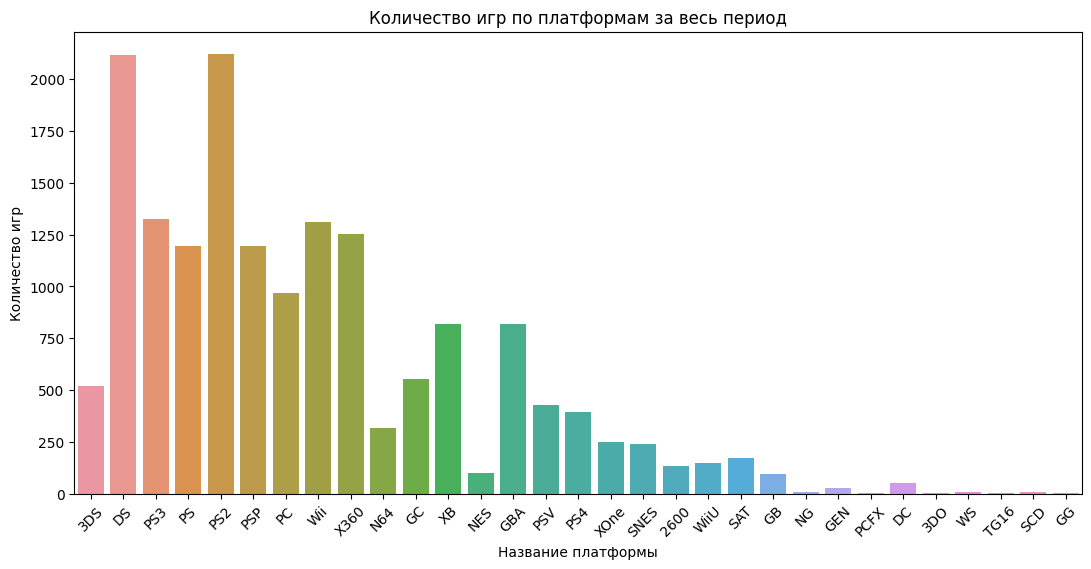

In [447]:
plt.figure(figsize=(13, 6))
sns.countplot(data=df, x=df.platform)
plt.title("Количество игр по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество игр")
plt.xticks(rotation=45)
plt.show()

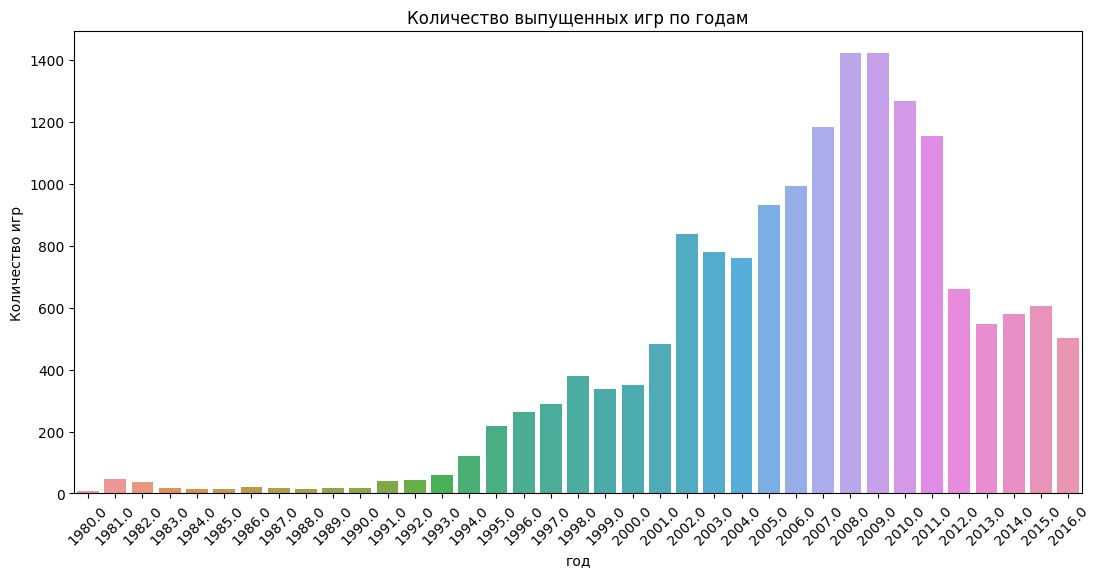

In [446]:
plt.figure(figsize=(13, 6))
sns.countplot(data=df, x='year_of_release')
plt.title("Количество выпущенных игр по годам")
plt.xlabel("год")
plt.ylabel("Количество игр")
plt.xticks(rotation=45)
plt.show()

* Пик геймдева пришелся на 2008-2009 года;
* до 1994 года выпускалось совсем мало игр.

У игровых платформ существует жизненный цикл, рассмотрим его и взглянем на самые прибыльные платформы.

In [454]:
platforms = df[['platform', 'year_of_release', 'total_sales']]\
    .pivot_table(
    index='platform', aggfunc={
        'total_sales': 'sum',
        'year_of_release': [np.min, np.max, lambda x: np.max(x)-np.min(x)+1]
    }).droplevel(0, axis=1).rename(
    columns={'amin': 'year_first', 'amax': 'year_last',
             '<lambda_0>': 'lifetime', 'sum': 'total_sales'}
).sort_values(by='total_sales', ascending=False)

platforms

,total_sales,lifetime,year_last,year_first
platform,,,,
PS2,1255.77,12.0,2011.0,2000.0
X360,971.42,12.0,2016.0,2005.0
PS3,939.65,12.0,2016.0,2005.0
Wii,907.51,11.0,2016.0,2006.0
DS,806.12,29.0,2013.0,1985.0
PS,730.86,10.0,2003.0,1994.0
GBA,317.85,8.0,2007.0,2000.0
PS4,314.14,4.0,2016.0,2013.0
PSP,294.05,12.0,2015.0,2004.0


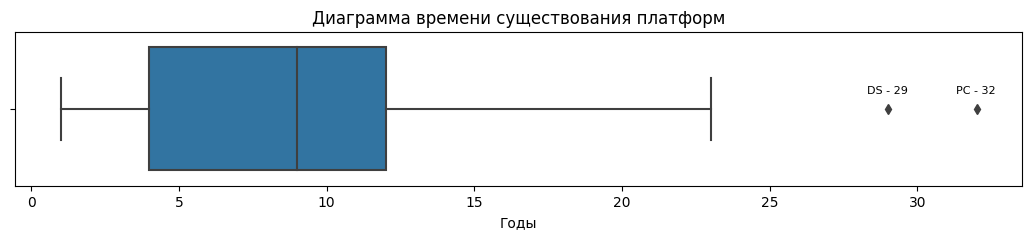

In [477]:
plt.subplots(figsize=(13, 2))
sns.boxplot(x=platforms['lifetime'])
plt.text(31.3, -0.1, 'PC - 32', color='black', fontsize=8)
plt.text(28.3, -0.1, 'DS - 29', color='black', fontsize=8)
plt.title('Диаграмма времени существования платформ')
plt.xlabel('Годы')
plt.show()

In [492]:
q_5 = np.quantile(platforms.lifetime, 0.05)
q_95 = np.quantile(platforms.lifetime, 0.95)

mask = (platforms.lifetime >= q_5) & (platforms.lifetime <= q_95)
lifetime = round(np.mean(platforms.lifetime[mask]))
print(f'Cредний жизненный цикл платформы : {lifetime} лет')

Cредний жизненный цикл платформы : 8 лет


Рассмотрим платформы, которые все еще "живы"

Так как ПК обладает более гибкой системой обновления и может иметь более длительный жизненный цикл по сравнению с консолями, оставим его в списке.

In [512]:
platforms = platforms.query('year_first > 2016 - @lifetime | platform == "PC"')

In [546]:
platform_sales = df.query('2016 - @lifetime < year_of_release & platform in @platforms.index')\
    .pivot_table(
    index='platform',
    columns='year_of_release',
    aggfunc={'total_sales': 'sum'}
).droplevel(0, axis=1)

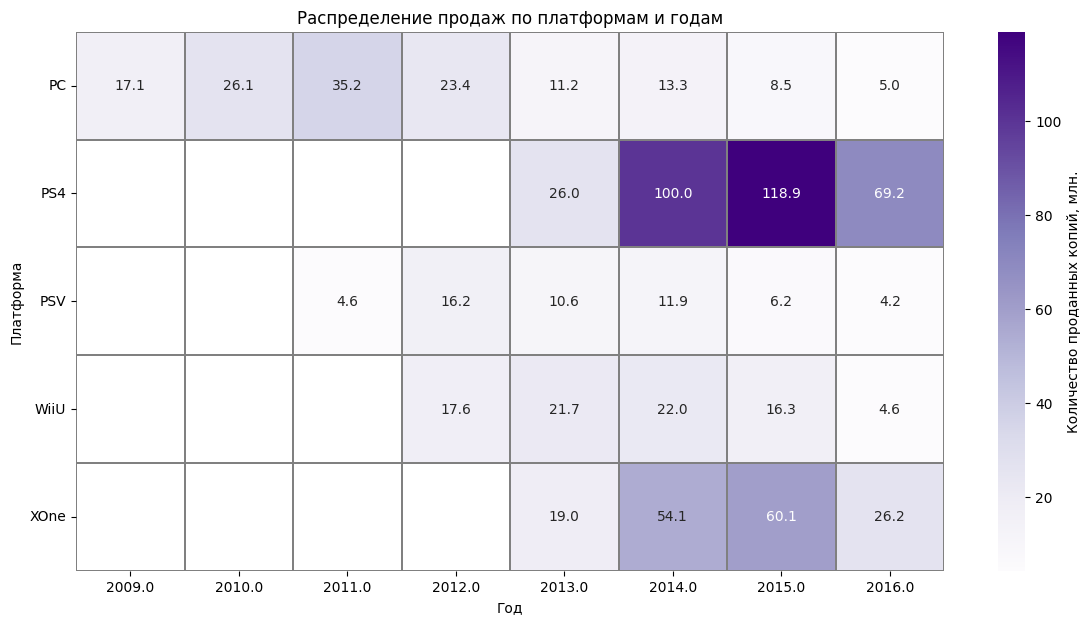

In [569]:
plt.subplots(figsize=(14, 7))
sns.heatmap(
    platform_sales,
    linewidths=0.05,
    linecolor='grey',
    annot=True,
    fmt='.1f',
    cmap='Purples',
    cbar_kws={'label': 'Количество проданных копий, млн.'}
)

plt.title('Распределение продаж по платформам и годам')
plt.xlabel('Год')
plt.ylabel('Платформа')
plt.yticks(rotation=0)
plt.show()

* Cамые популярные платформы - PS4 и XOne.

In [547]:
df_actual = df.query('2016 - @lifetime < year_of_release & platform in @platforms.index')

In [548]:
df_actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
44,15 Days,PC,2009.0,Adventure,0.00,0.01,0.00,0.00,63.0,58.0,None,0.01
48,18 Wheels of Steel: Extreme Trucker,PC,2009.0,Racing,0.00,0.02,0.00,0.00,NaN,80.0,None,0.02
49,18 Wheels of Steel: Extreme Trucker 2,PC,2011.0,Racing,0.08,0.02,0.00,0.01,NaN,83.0,E,0.11
86,3rd Super Robot Wars Z Jigoku Hen,PSV,2014.0,Role-Playing,0.00,0.00,0.19,0.00,NaN,NaN,None,0.19
88,3rd Super Robot Wars Z: Tengoku-Hen,PSV,2015.0,Action,0.00,0.00,0.19,0.00,NaN,NaN,None,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...
16536,Zumba Fitness: World Party,XOne,2013.0,Misc,0.17,0.05,0.00,0.02,73.0,62.0,E,0.24
16539,[Prototype 2],PC,2012.0,Action,0.07,0.03,0.00,0.01,76.0,64.0,M,0.11
16554,htoL#NiQ: The Firefly Diary,PSV,2014.0,Platform,0.00,0.00,0.01,0.00,58.0,77.0,T,0.01
16561,inFAMOUS: Second Son,PS4,2014.0,Action,1.28,0.98,0.07,0.46,80.0,79.0,T,2.79


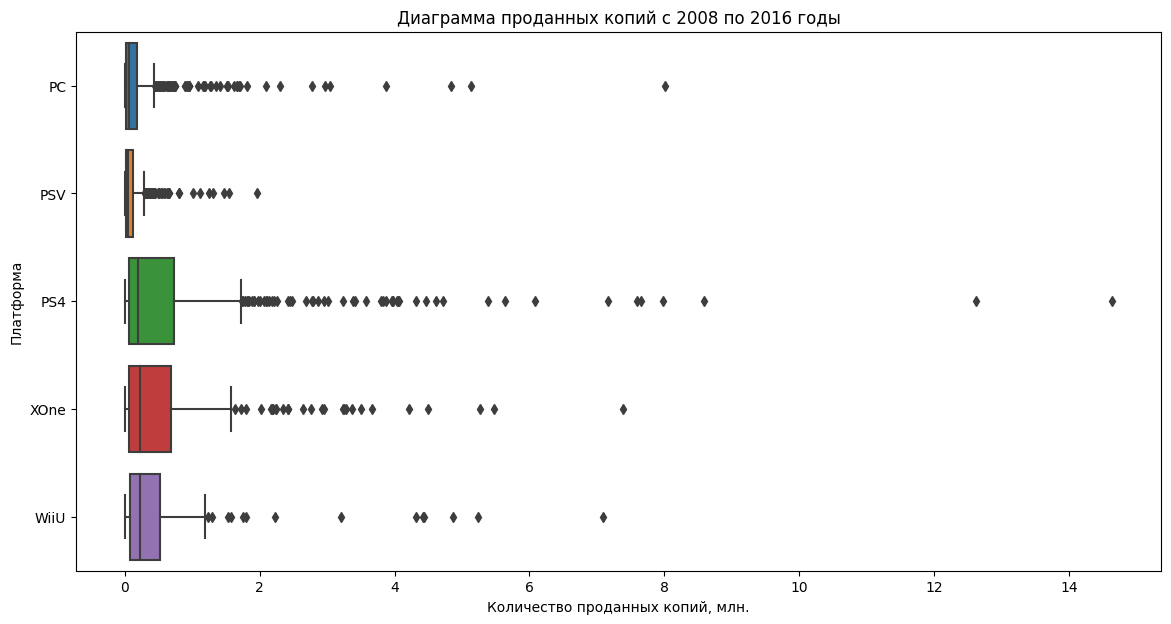

In [568]:
plt.subplots(figsize=(14, 7))
sns.boxplot(x=df_actual.total_sales, y=df_actual.platform)
plt.title('Диаграмма проданных копий с 2008 по 2016 годы')
plt.xlabel('Количество проданных копий, млн.')
plt.ylabel('Платформа')
plt.show()

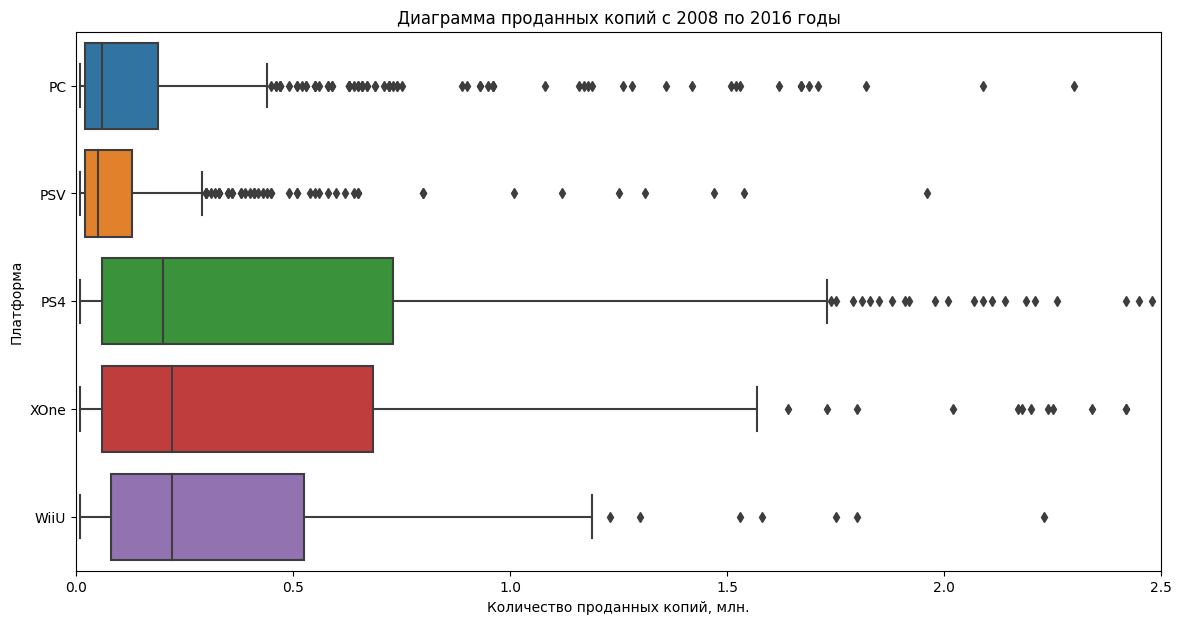

In [567]:
plt.subplots(figsize = (14,7))
sns.boxplot(x=df_actual.total_sales, y=df_actual.platform)
plt.title('Диаграмма проданных копий с 2008 по 2016 годы')
plt.xlabel('Количество проданных копий, млн.')
plt.ylabel('Платформа')
plt.xlim(0, 2.5)
plt.show()

* Значения, выходящие за пределы ящика с усами говорят о том, что игры выходящие на PS4, XOne и PC могут стать наиболее успешными;
* На WiiU игры по медиане самые дорогие.

In [562]:
best_platforms = ['PS4', "XOne", "WiiU"]

Рассмотрим, как коррелируют различные показатели с продажами

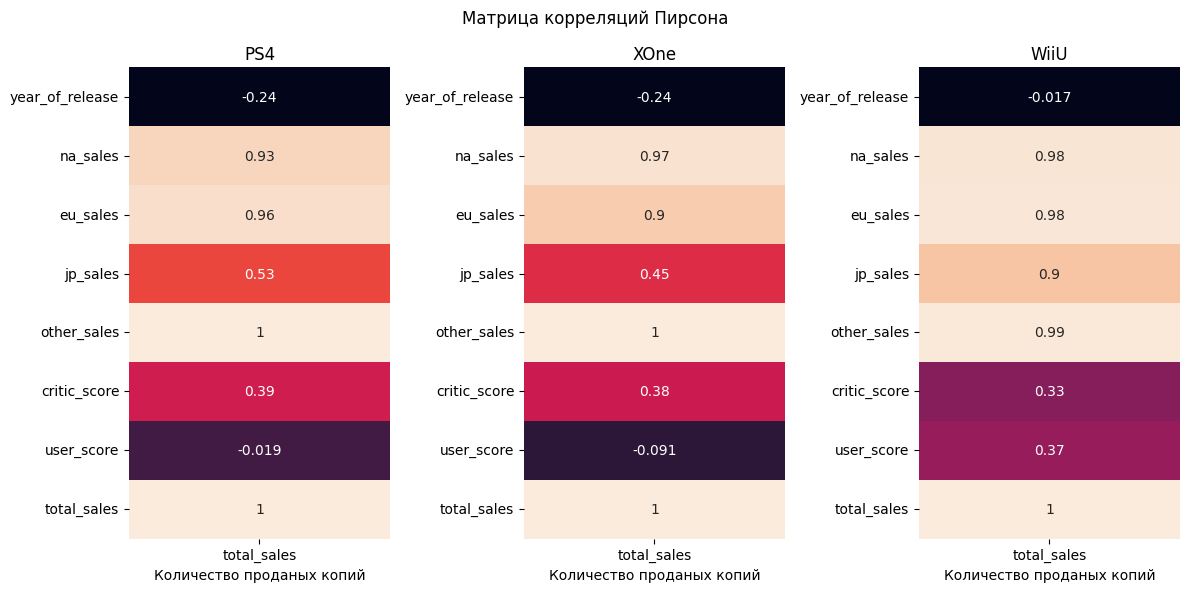

In [612]:
fig = plt.figure(figsize=(12, 6))
for i, platform in enumerate(best_platforms):
    ax = fig.add_subplot(1, 3, i+1)
    sns.heatmap(
        data=df_actual[df_actual['platform'] == platform]
        .corr()[['total_sales']],
        annot=True,
        ax=ax,
        cbar=False
    )
    ax.set_title(platform)
    ax.set_xlabel('Количество проданых копий')

plt.suptitle('Матрица корреляций Пирсона')
fig.tight_layout()
plt.show()

* Оценки критиков влияют на продажи;
* В японии PS4 и XOne не так популярны как WiiU.

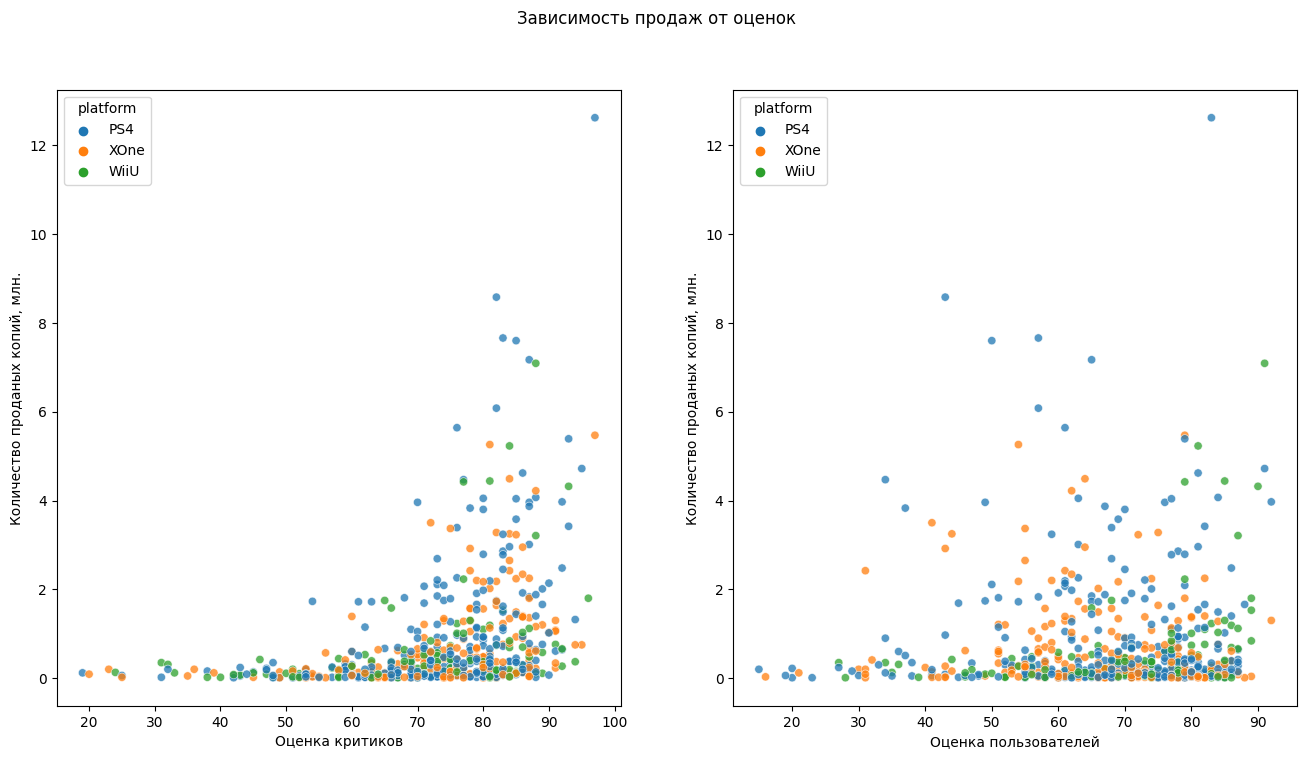

In [573]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

sns.scatterplot(
    data=df_actual.query("platform in @best_platforms"),
    ax=ax[0], x='critic_score', y='total_sales',
    hue='platform', alpha=0.75
)
sns.scatterplot(
    data=df_actual.query("platform in @best_platforms"),
    ax=ax[1], x='user_score', y='total_sales',
    hue='platform', alpha=0.75
)
ax[0].set_xlabel('Оценка критиков')
ax[0].set_ylabel('Количество проданых копий, млн.')
ax[1].set_xlabel('Оценка пользователей')
ax[1].set_ylabel('Количество проданых копий, млн.')
plt.suptitle("Зависимость продаж от оценок")
plt.show()

* Дисперсия оценок пользователей более высокая, чем у критиков;
* На WiiU оценки критиков и пользователей примерно одинаковые.


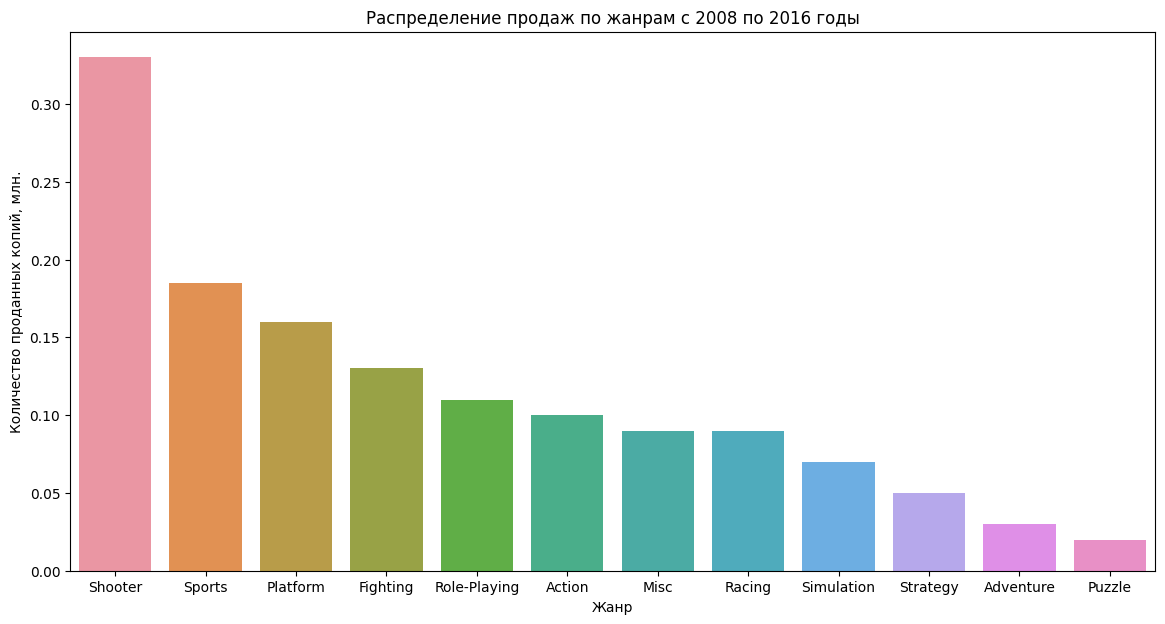

In [648]:
plt.subplots(figsize=(14, 7))

sns.barplot(
    data=df_actual,
    order=df_actual.groupby('genre').median().total_sales\
    .sort_values(ascending=False).index,
    x='genre',
    y='total_sales',
    estimator='median',
    ci=None
)
plt.title("Распределение продаж по жанрам с 2008 по 2016 годы")
plt.xlabel('Жанр')
plt.ylabel("Количество проданных копий, млн.")
plt.show()

In [764]:
df_melted = pd.melt(df_actual, id_vars=['genre'], 
                    value_vars=['na_sales', 'eu_sales', 'jp_sales' ,'other_sales'], 
                    var_name='sale_type', 
                    value_name='sale')

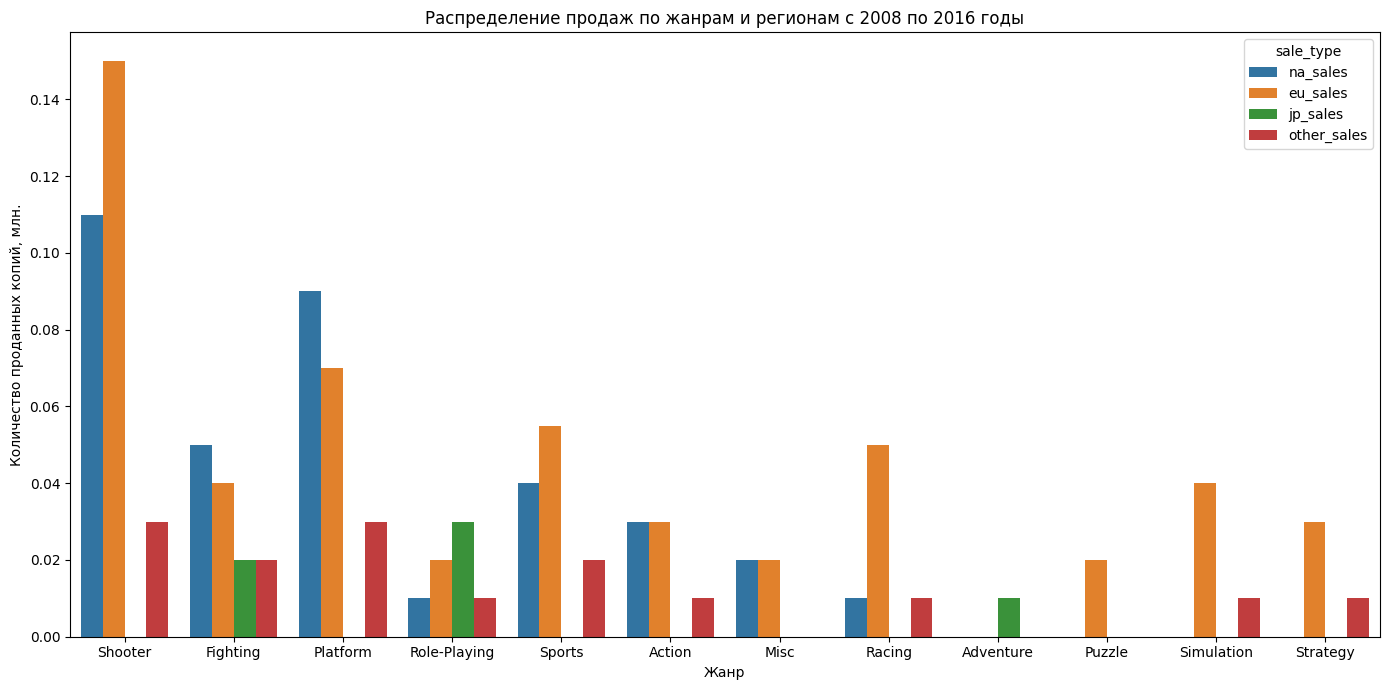

In [765]:
plt.subplots(figsize=(14, 7))

sns.barplot(
    data=df_melted,
    order=df_melted.groupby('genre').median()
    .sort_values(by='sale', ascending=False).index,
    x='genre',
    y='sale',
    hue='sale_type',
    estimator='median',
    ci=None
)

plt.title("Распределение продаж по жанрам и регионам с 2008 по 2016 годы")
plt.xlabel('Жанр')
plt.ylabel("Количество проданных копий, млн.")

plt.tight_layout()
plt.show()

* Наиболее популярным жанром являются шутеры и спортивные симуляторы;
* Некоторые жанры пользуются популярностью только в отдельных регионах, например пазлы в европе, а приключения в Японии;
* Большинство жанров в японском регионе представлены незначительно;
* Пазлы и приключенческие игры плохо продаются.

In [759]:
df_actual['rating'] = df_actual['rating'].fillna('unknown')

In [761]:
df_melted_rating = pd.melt(df_actual, id_vars=['rating'], 
                    value_vars=['na_sales', 'eu_sales', 'jp_sales' ,'other_sales'], 
                    var_name='sale_type', 
                    value_name='sale')

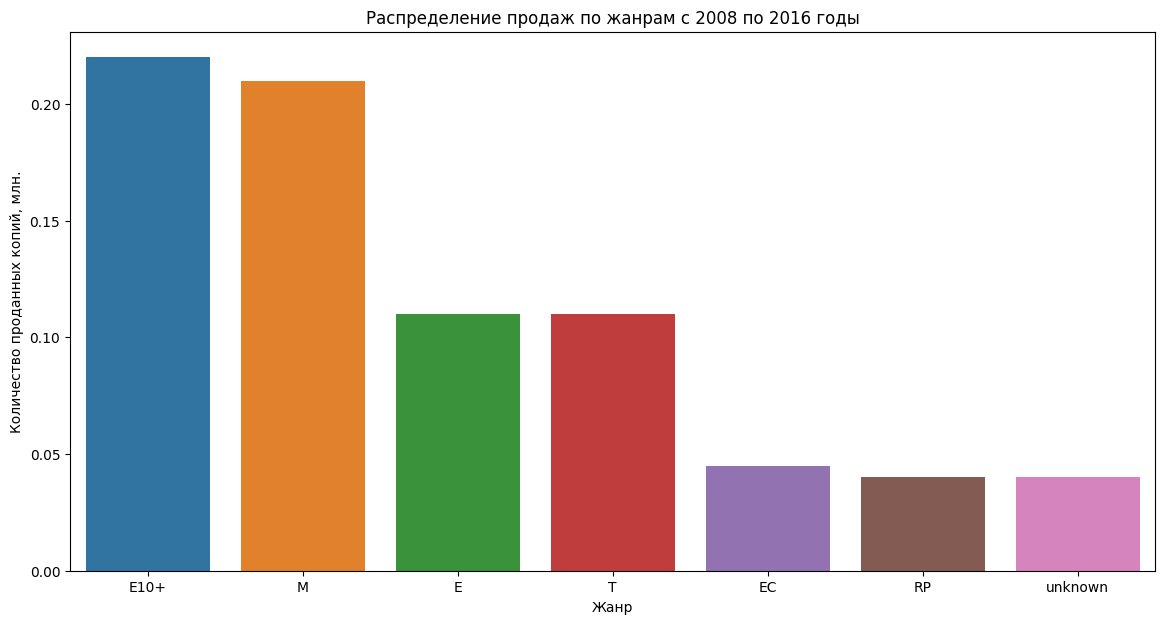

In [779]:
plt.subplots(figsize=(14, 7))

sns.barplot(
    data=df_actual,
    order=df_actual.groupby('rating').median().total_sales\
    .sort_values(ascending=False).index,
    x='rating',
    y='total_sales',
    estimator='median',
    ci=None
)
plt.title("Распределение продаж по жанрам с 2008 по 2016 годы")
plt.xlabel('Жанр')
plt.ylabel("Количество проданных копий, млн.")
plt.show()

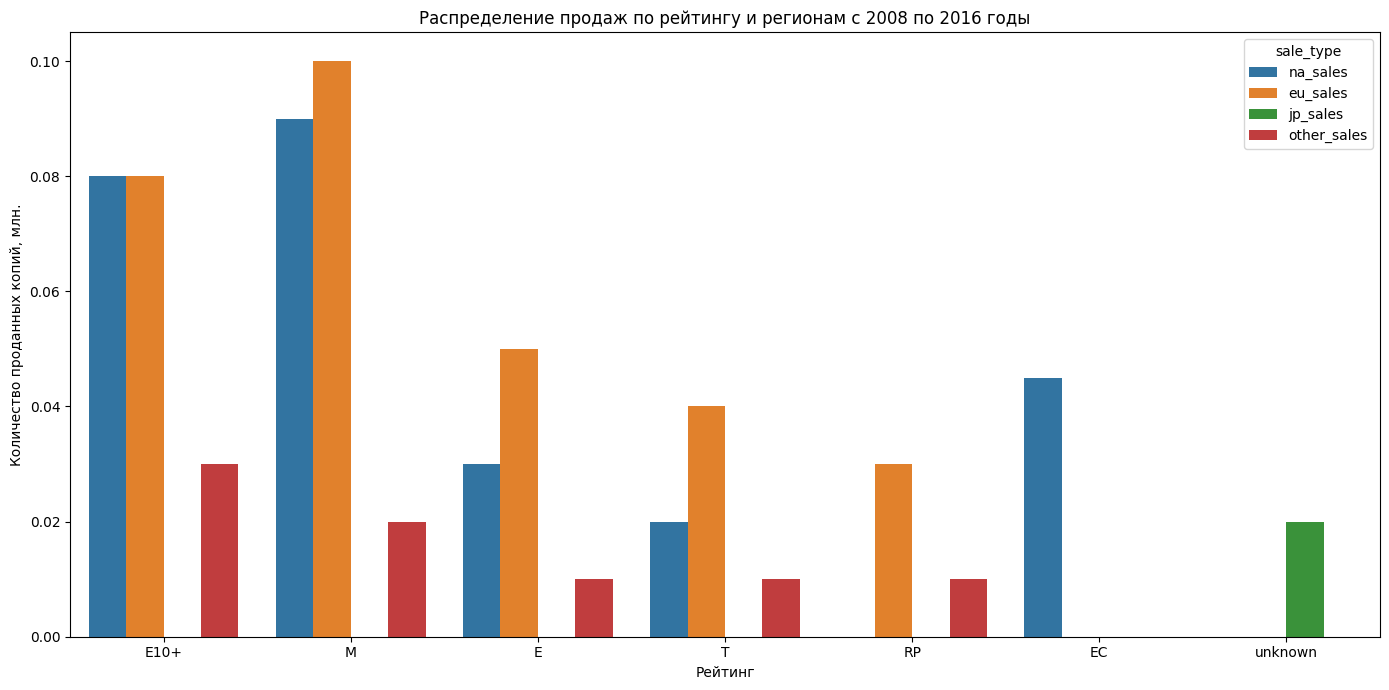

In [780]:
plt.subplots(figsize=(14, 7))

sns.barplot(
    data=df_melted_rating,
    order=df_melted_rating.groupby('rating').median()
    .sort_values(by='sale', ascending=False).index,
    x='rating',
    y='sale',
    hue='sale_type',
    estimator='median',
    ci=None
)

plt.title("Распределение продаж по рейтингу и регионам с 2008 по 2016 годы")
plt.xlabel('Рейтинг')
plt.ylabel("Количество проданных копий, млн.")

plt.tight_layout()
plt.show()

* Рейтинг большинству игр в Японии не присваивается организацией ESRB;
* Наиболее популярным рейтингом является EC10+ «Для всех от 10 лет и старше», наименее популярным - EC «Для детей младшего возраста»

# A / B tests

*Гипотеза №1* : cредние оценки критиков игр на платформах _XOne_ и _PS4_ одинаковые.

Сформулируем нулевую и альтернативную гипотезы. 

- **H0** (Нулевая гипотеза): _Средние рейтинги критиков игр на платформах XOne и _PS4_ **равны**_
- **H1** (Альтернативная гипотеза) : _Средние рейтинги критиков игр на платформах XOne и _PS4_ **различаются**_


In [824]:
xOne_ratings = df_actual.query("platform == 'XOne'")['critic_score'].dropna()
ps4_ratings = df_actual.query("platform == 'PS4'")['critic_score'].dropna()

In [803]:
# Посмотрим на количество объектов в группах
print(f'Игр на платформе ХОne: {len(xOne_ratings)}\n\
Игр на платформе PS4: {len(ps4_ratings)}')

Игр на платформе ХОne: 247
Игр на платформе PS4: 392


In [828]:
pd.concat({
    'XOne': xOne_ratings.describe(),
    'PS4': ps4_ratings.describe()
}, axis=1).round(1)

,XOne,PS4
count,204.0,287.0
mean,73.7,72.7
std,13.0,12.5
min,20.0,19.0
25%,67.0,67.0
50%,76.5,74.0
75%,83.0,81.0
max,97.0,97.0


Оценим p-value - для того, чтобы определить, что различия между группами не являются случайным.
Уровень статистической значимости $\alpha$ возьмёи равныи 0.05.
Так как стандартные отклонения выборок отличаются не сильно и размеры выборок малы.

Проверим выборки на нормальность распределения.

In [834]:
# Проверяем нормальность распределения выборок
alpha = 0.05

p = shapiro(xOne_ratings).pvalue
print('Распределениие в выборке XOne:', 'p=%.3f' % (p))

if p > alpha:
    print('Распределение похоже на нормальное (не отвергаем H0)')
else:
    print('Распределение не похоже на нормальное (отвергаем H0)')
    
p = shapiro(ps4_ratings).pvalue
print('Распределениие в выборке PS4:', 'p=%.3f' % (p))

if p > alpha:
    print('Распределение похоже на нормальное (не отвергаем H0)')
else:
    print('Распределение не похоже на нормальное (отвергаем H0)')

Распределениие в выборке XOne: p=0.000
Распределение не похоже на нормальное (отвергаем H0)
Распределениие в выборке PS4: p=0.000
Распределение не похоже на нормальное (отвергаем H0)


Так как тест Шапиро-Уилка показал, что данные распределены не нормально и размер выборки не велик, вместо т-теста будем использовать тест Манна-Уитни.

In [833]:
pvalue = mannwhitneyu(xOne_ratings, ps4_ratings).pvalue

print('p-значение:  {:.2%}'.format(pvalue))

if pvalue > alpha:
    print("Принимаем гипотезу: Средние пользовательские рейтинги платформ Xbox One и PS4 равны")
else:
    print("Принимаем гипотезу: Средние пользовательские рейтинги платформ Xbox One и PS4 различаются")

p-значение:  16.64%
Принимаем гипотезу: Средние пользовательские рейтинги платформ Xbox One и PS4 равны


p-value показало, что получить случайно такое или больее серьезное различие в средних значениях равно 16.64 %, следовательно отвергнуть нулевую гипотезу нельзя. 

Гипотеза №2 : cредние оценки пользователей на платформах XOne и PS4 одинаковые.

Сформулируем нулевую и альтернативную гипотезы.

H0 (Нулевая гипотеза): Средние рейтинги пользователей на платформах XOne и PS4 равны
H1 (Альтернативная гипотеза) : Средние рейтинги пользователей на платформах XOne и PS4 различаются

In [843]:
Action_ratings = df_actual.query("genre == 'Action'")['user_score'].dropna()
Sports_ratings = df_actual.query("genre == 'Sports'")['user_score'].dropna()

In [844]:
# Проверяем нормальность распределения выборок
alpha = 0.05

p = shapiro(Action_ratings).pvalue
print('Распределениие в выборке XOne:', 'p=%.3f' % (p))

if p > alpha:
    print('Распределение похоже на нормальное (не отвергаем H0)')
else:
    print('Распределение не похоже на нормальное (отвергаем H0)')
    
p = shapiro(Sports_ratings).pvalue
print('Распределениие в выборке PS4:', 'p=%.3f' % (p))

if p > alpha:
    print('Распределение похоже на нормальное (не отвергаем H0)')
else:
    print('Распределение не похоже на нормальное (отвергаем H0)')

Распределениие в выборке XOne: p=0.000
Распределение не похоже на нормальное (отвергаем H0)
Распределениие в выборке PS4: p=0.005
Распределение не похоже на нормальное (отвергаем H0)


In [847]:
pvalue = mannwhitneyu(Action_ratings, Sports_ratings).pvalue

print('p-значение:  {:.2%}'.format(pvalue))

if pvalue > alpha:
    print("Принимаем гипотезу: Средние пользовательские рейтинги платформ Xbox One и PS4 равны")
else:
    print("Принимаем гипотезу: Средние пользовательские рейтинги платформ Xbox One и PS4 различаются")

p-значение:  0.00%
Принимаем гипотезу: Средние пользовательские рейтинги платформ Xbox One и PS4 различаются


p-value показало нулевую вероятность получить такое же или большее различие средних значений случайно. Поэтому нулевую гипотезу необходимо отвегрнуть.